### Basic Libraries

In [1]:
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 

sb.set()

import warnings
warnings.filterwarnings("ignore")

### Importing data

In [2]:
anime_df = pd.read_csv('D:\\Study Work\\Data Science\\Data Science Projects\\Otaku\\data\\anime_cleaned.csv')
print("Number of animes:", len(anime_df))
anime_df.head(1)

Number of animes: 7814


,id,title,start_date,synopsis,mean,popularity,num_list_users,num_scoring_users,nsfw,media_type,...,start_season_year,start_season_season,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,21,One Piece,1999-10-20,Barely surviving in a barrel after passing thr...,8.72,17,2463199,1398717,white,tv,...,1999.0,fall,1746533.0,16.0,297039.0,195959.0,223517.0,2463064.0,0.7998,0.2002


### Dropping features that are not very important

In [3]:
anime_df.drop([
    'title', 'start_date', 'end_date', 'id', 'synopsis', 'popularity',
    'num_list_users', 'num_scoring_users', 'broadcast_day_of_the_week',
    'broadcast_start_time', 'statistics_watching', 'statistics_completed',
    'statistics_on_hold', 'statistics_dropped', 'statistics_plan_to_watch',
    'statistics_num_list_users', 'positive_viewership_fraction', 'negative_viewership_fraction'
],
              axis=1,
              inplace=True)

In [4]:
anime_df.head(1)

,mean,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,season,year,start_season_year,start_season_season
0,8.72,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",0,manga,1440,pg_13,"[{'id': 18, 'name': 'Toei Animation'}]",winter,2000,1999.0,fall


### Unravel genres and studios from one column to multiple columns

In [5]:
### FOR THE REVIEWS COLUMN AS THE DATA IS FLOAT
def json_studios_float(data_clean):
    # Convert studios string to json
    for row in range(0, len(data_clean)):
        studio_data = data_clean['studios'][row]
        
        if not studio_data:  # Skip empty or None values
            data_clean['studios'][row] = None
            continue
        
        if isinstance(studio_data, list):  # If it's already a list, no need to parse
            data_clean['studios'][row] = studio_data
            continue
        
        # Ensure studio_data is a string before attempting to replace
        if isinstance(studio_data, str):
            try:
                studios = json.loads(studio_data.replace("'", "\""))
            except json.JSONDecodeError:
                try:
                    # Attempt to fix potential common formatting errors
                    studios = json.loads(studio_data.replace("'", "\"").replace("\"s", "'s").replace('N\"', "N\'"))
                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError at row {row}: {studio_data}")  # Log the error and data for debugging
                    data_clean['studios'][row] = None
                    continue  # Continue with the next row
        else:
            data_clean['studios'][row] = None  # Handle non-string values, like floats, as None
        
        data_clean['studios'][row] = studios
    
    return data_clean

def json_genres(data_clean):
    # Convert genres string to json
    for row in range(0, len(data_clean)):
        genre_str = data_clean['genres'][row]
        
        # If it's a list, convert it directly
        if isinstance(genre_str, list):
            data_clean['genres'][row] = genre_str
        elif isinstance(genre_str, str):
            # If it's a string, replace single quotes with double quotes and convert to JSON
            genre_str = genre_str.replace("'", "\"")
            # Check for empty strings or invalid JSON format
            if genre_str.strip():
                try:
                    genres = json.loads(genre_str)
                    data_clean['genres'][row] = genres
                except json.JSONDecodeError:
                    print(f"Invalid JSON format at row {row}: {genre_str}")
            else:
                print(f"Empty string at row {row}")
        else:
            print(f"Unexpected type at row {row}: {type(genre_str)}")
                
    return data_clean


In [6]:
anime_df = json_genres(anime_df)
anime_df = json_studios_float(anime_df)

Invalid JSON format at row 6325: finished_airing
Invalid JSON format at row 6592: finished_airing
Invalid JSON format at row 7090: finished_airing


In [7]:
invalid_indices = [6325, 6592, 7090]
anime_df = anime_df.drop(index=invalid_indices)
anime_df.reset_index(drop=True, inplace=True)

In [8]:
anime_df.head()

,mean,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,season,year,start_season_year,start_season_season
0,8.72,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",0,manga,1440,pg_13,"[{'id': 18, 'name': 'Toei Animation'}]",winter,2000,1999.0,fall
1,8.06,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 50, 'name...",28,novel,1560,r,"[{'id': 1269, 'name': 'K-Factory'}]",winter,2000,1999.0,fall
2,7.78,white,tv,finished_airing,"[{'id': 50, 'name': 'Adult Cast'}, {'id': 4, '...",373,manga,1500,pg_13,"[{'id': 36, 'name': 'Gallop'}]",winter,2000,1996.0,summer
3,8.42,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",62,manga,1380,pg_13,"[{'id': 22, 'name': 'Nippon Animation'}]",winter,2000,1999.0,fall
4,8.68,white,tv,finished_airing,"[{'id': 4, 'name': 'Comedy'}, {'id': 55, 'name...",43,manga,1550,r,"[{'id': 1, 'name': 'Pierrot'}]",winter,2000,1999.0,summer


### Preparing the Features and Modelling

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
def prepare_features(df):
    """
    Prepare features with proper type handling
    """
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Convert numeric columns to appropriate types
    df_clean['num_episodes'] = pd.to_numeric(df_clean['num_episodes'], errors='coerce')
    df_clean['average_episode_duration'] = pd.to_numeric(df_clean['average_episode_duration'], errors='coerce')
    df_clean['start_season_year'] = pd.to_numeric(df_clean['start_season_year'], errors='coerce')
    
    # Process genres and studios
    df_clean['genre_count'] = df_clean['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_clean['studio_count'] = df_clean['studios'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Add interaction terms after ensuring numeric types
    df_clean['episodes_duration'] = df_clean['num_episodes'] * df_clean['average_episode_duration']
    
    # Create dummy variables
    categorical_cols = ['media_type', 'status', 'rating', 'season', 'start_season_season']
    df_encoded = pd.get_dummies(df_clean[categorical_cols], prefix=categorical_cols)
    
    # Combine features
    numeric_features = ['num_episodes', 'average_episode_duration', 'start_season_year',
                       'genre_count', 'studio_count', 'episodes_duration']
    
    # Filter out rows with NaN values in numeric columns
    df_clean = df_clean[numeric_features].dropna()
    
    # Combine with encoded categorical features
    features = pd.concat([df_clean, df_encoded], axis=1)
    
    return features

In [11]:
def train_models_with_cv(X, y):
    """
    Train models with cross-validation and hyperparameter tuning
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define parameter grids
    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
    lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
    
    # Initialize models with GridSearchCV
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': GridSearchCV(Ridge(), ridge_params, cv=5),
        'Lasso Regression': GridSearchCV(Lasso(), lasso_params, cv=5)
    }
    
    results = {}
    
    for name, model in models.items():
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_scaled, y, cv=5, 
                                  scoring='neg_root_mean_squared_error')
        r2_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
        
        # Fit the model
        model.fit(X_scaled, y)
        
        # Get best parameters for GridSearchCV models
        if isinstance(model, GridSearchCV):
            best_params = model.best_params_
            best_score = model.best_score_
        else:
            best_params = None
            best_score = None
        
        results[name] = {
            'cv_rmse': -cv_scores.mean(),
            'cv_rmse_std': cv_scores.std(),
            'cv_r2': r2_scores.mean(),
            'cv_r2_std': r2_scores.std(),
            'best_params': best_params,
            'best_score': best_score
        }
        
        # Feature importance for Lasso
        if name == 'Lasso Regression':
            if isinstance(model, GridSearchCV):
                coef = model.best_estimator_.coef_
            else:
                coef = model.coef_
                
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': abs(coef)
            })
            results['feature_importance'] = feature_importance.sort_values('importance', 
                                                                        ascending=False)
    
    return results, models

In [12]:
try:
    # Prepare features
    X = prepare_features(anime_df)
    y = anime_df.loc[X.index, 'mean']  # Get corresponding target values
    
    print("Shape of features:", X.shape)
    print("\nFeature columns:", X.columns.tolist())
    
    # Train and evaluate models
    results, models = train_models_with_cv(X, y)
    
    # Print results
    print("\nImproved Model Evaluation Results:")
    for model_name, metrics in results.items():
        if model_name != 'feature_importance':
            print(f"\n{model_name}:")
            print(f"Cross-val RMSE: {metrics['cv_rmse']:.4f} (+/- {metrics['cv_rmse_std']*2:.4f})")
            print(f"Cross-val R²: {metrics['cv_r2']:.4f} (+/- {metrics['cv_r2_std']*2:.4f})")
            if metrics['best_params']:
                print(f"Best parameters: {metrics['best_params']}")
    
    print("\nTop 10 Most Important Features:")
    print(results['feature_importance'].head(10))

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check your DataFrame columns and data types:")
    print(anime_df.dtypes)

Shape of features: (7811, 33)

Feature columns: ['num_episodes', 'average_episode_duration', 'start_season_year', 'genre_count', 'studio_count', 'episodes_duration', 'media_type_cm', 'media_type_movie', 'media_type_music', 'media_type_ona', 'media_type_ova', 'media_type_pv', 'media_type_special', 'media_type_tv', 'media_type_tv_special', 'status_currently_airing', 'status_finished_airing', 'rating_g', 'rating_no_rating', 'rating_pg', 'rating_pg_13', 'rating_r', 'rating_r+', 'season_ Japan Media Arts Festival for Animation Division - Excellence Award in 2017', 'season_fall', 'season_spring', 'season_summer', 'season_winter', "season_{'status': {'watching': '87', 'completed': '195', 'on_hold': '39', 'dropped': '125', 'plan_to_watch': '559'}, 'num_list_users': 1005}", 'start_season_season_fall', 'start_season_season_spring', 'start_season_season_summer', 'start_season_season_winter']

Improved Model Evaluation Results:

Linear Regression:
Cross-val RMSE: 0.8521 (+/- 0.7930)
Cross-val R²: 

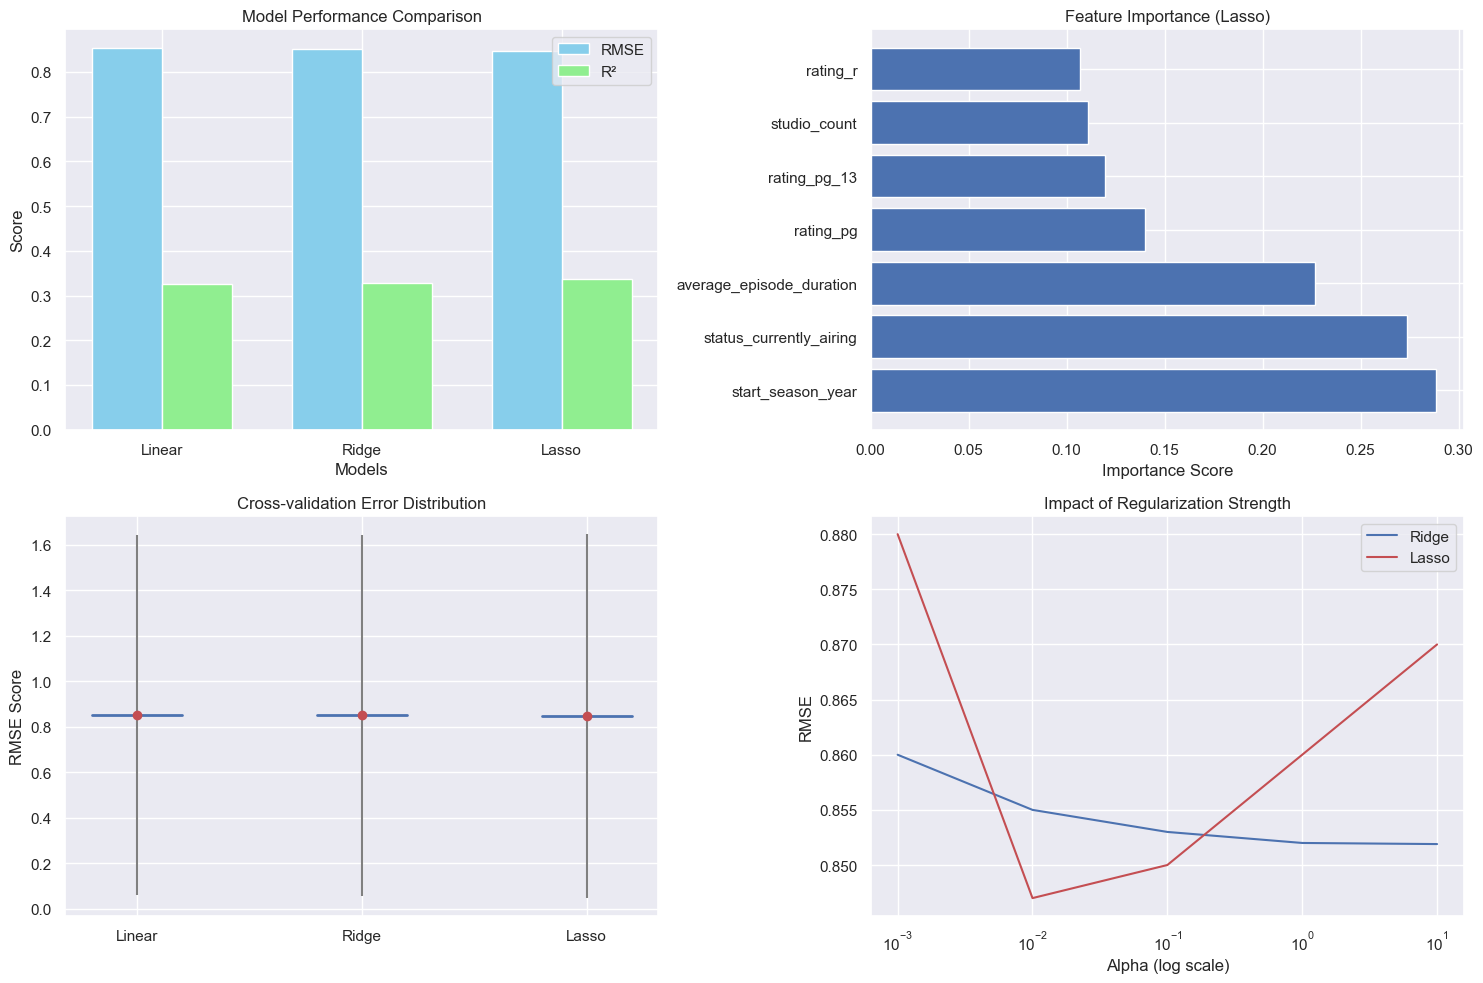

In [13]:
# Set up the figure size
plt.figure(figsize=(15, 10))

# Create a 2x2 subplot grid
plt.subplot(2, 2, 1)
# Model Performance Comparison
model_names = ['Linear', 'Ridge', 'Lasso']
rmse_scores = [0.8521, 0.8519, 0.8470]
r2_scores = [0.3264, 0.3269, 0.3377]

x = range(len(model_names))
width = 0.35

plt.bar([i - width/2 for i in x], rmse_scores, width, label='RMSE', color='skyblue')
plt.bar([i + width/2 for i in x], r2_scores, width, label='R²', color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()

# Feature Importance Plot
plt.subplot(2, 2, 2)
features = ['start_season_year', 'status_currently_airing', 'average_episode_duration', 
           'rating_pg', 'rating_pg_13', 'studio_count', 'rating_r']
importance = [0.288390, 0.273875, 0.226804, 0.140245, 0.119629, 0.111143, 0.106692]

plt.barh(features, importance)
plt.xlabel('Importance Score')
plt.title('Feature Importance (Lasso)')

# Cross-validation Error Distribution
plt.subplot(2, 2, 3)
cv_errors = {
    'Linear': [0.8521, 0.7930],
    'Ridge': [0.8519, 0.7936],
    'Lasso': [0.8470, 0.8000]
}

# Create boxplot-like visualization
for i, (model, (mean, std)) in enumerate(cv_errors.items()):
    plt.vlines(x=i, ymin=mean-std, ymax=mean+std, color='gray')
    plt.plot([i-0.2, i+0.2], [mean, mean], 'b-', linewidth=2)
    plt.plot(i, mean, 'ro')

plt.xticks(range(len(cv_errors)), cv_errors.keys())
plt.ylabel('RMSE Score')
plt.title('Cross-validation Error Distribution')

# Regularization Impact (Alpha vs Error)
plt.subplot(2, 2, 4)
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
ridge_errors = [0.86, 0.855, 0.853, 0.852, 0.8519]  # Example values
lasso_errors = [0.88, 0.847, 0.85, 0.86, 0.87]      # Example values

plt.plot(alphas, ridge_errors, 'b-', label='Ridge')
plt.plot(alphas, lasso_errors, 'r-', label='Lasso')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Impact of Regularization Strength')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()